<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Домашнее задание. Обучение языковой модели с помощью LSTM (10 баллов)


В этом задании Вам предстоит обучить языковую модель с помощью рекуррентной нейронной сети. В отличие от семинарского занятия, Вам необходимо будет работать с отдельными словами, а не буквами.


Установим модуль ```datasets```, чтобы нам проще было работать с данными.

In [1]:
!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.6 MB/s eta 0:00:00


Импорт необходимых библиотек

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
import datasets
from datasets import load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List, Tuple
import string
import random
import os

import seaborn
seaborn.set(palette='summer')

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
def fixedseed (seed: int=42):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

In [6]:
fixedseed()

## Подготовка данных

Воспользуемся датасетом imdb. В нем хранятся отзывы о фильмах с сайта imdb. Загрузим данные с помощью функции ```load_dataset```

In [ ]:
# Загрузим датасет
dataset = load_dataset('imdb')

README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

### Препроцессинг данных и создание словаря (1 балл)

Далее вам необходмо самостоятельно произвести препроцессинг данных и получить словарь или же просто ```set``` строк. Что необходимо сделать:

1. Разделить отдельные тренировочные примеры на отдельные предложения с помощью функции ```sent_tokenize``` из бибилиотеки ```nltk```. Каждое отдельное предложение будет одним тренировочным примером.
2. Оставить только те предложения, в которых меньше ```word_threshold``` слов.
3. Посчитать частоту вхождения каждого слова в оставшихся предложениях. Для деления предлоения на отдельные слова удобно использовать функцию ```word_tokenize```.
4. Создать объект ```vocab``` класса ```set```, положить в него служебные токены '\<unk\>', '\<bos\>', '\<eos\>', '\<pad\>' и vocab_size самых частовстречающихся слов.   

In [ ]:
dataset['test']['text'][-1]

'I caught this movie on the Sci-Fi channel recently. It actually turned out to be pretty decent as far as B-list horror/suspense films go. Two guys (one naive and one loud mouthed a**) take a road trip to stop a wedding but have the worst possible luck when a maniac in a freaky, make-shift tank/truck hybrid decides to play cat-and-mouse with them. Things are further complicated when they pick up a ridiculously whorish hitchhiker. What makes this film unique is that the combination of comedy and terror actually work in this movie, unlike so many others. The two guys are likable enough and there are some good chase/suspense scenes. Nice pacing and comic timing make this movie more than passable for the horror/slasher buff. Definitely worth checking out.'

In [ ]:
sentences = []
word_threshold = 32
# Получить отдельные предложения и поместить их в sentences
for txt in tqdm(dataset['train']['text']+dataset['test']['text']+dataset['unsupervised']['text']): # используем 100 000 текстов для создания нашей выборки
    sentences.extend(
        [sentence.lower() for sentence in sent_tokenize(txt) if len(word_tokenize(sentence)) < word_threshold]
        )
sentences[-1]

  0%|          | 0/100000 [00:00<?, ?it/s]

"this end of the 80's piece is as dark as it got back then."

In [ ]:
print("Всего предложений:", len(sentences))

Всего предложений: 786666


Из 100 000 текстов получили ок 787 000 отдельных предложений

In [ ]:
print("Количество полных дубликатов:", len(sentences) - len(set(sentences)))

Количество полных дубликатов: 40866


Избавимся от дубликатов

In [ ]:
sentences = list(set(sentences))
sentences[-1]

'i thought this might be one of those films that would be "good for me" to see.'

In [ ]:
sentences[0:6]

["by the end of the movie we've learned peter is dogged and desperate, but slowly figuring things out.",
 "according to 'jake speed' they are based on real people, living out the adventures they write about and publish.",
 "there are some funny situations; but if you've seen the trailers you have seen the substance of the film.",
 'predictable, but lots of fun!',
 "that weird aspect makes it into one of the least predictable and funny shows i've watched in a while.",
 "it's the original soundtrack, filmed on location, so don't expect to hear a word the cast says."]

In [ ]:
print("Количество предложений без дубликатов:", len(sentences))

Количество предложений без дубликатов: 745800


Посчитаем для каждого слова его встречаемость.

In [ ]:
wordlists = []
for s in tqdm(sentences):
    wordlists.extend([word_tokenize(s)])
wordlists[0:2]

  0%|          | 0/745800 [00:00<?, ?it/s]

[['by',
  'the',
  'end',
  'of',
  'the',
  'movie',
  'we',
  "'ve",
  'learned',
  'peter',
  'is',
  'dogged',
  'and',
  'desperate',
  ',',
  'but',
  'slowly',
  'figuring',
  'things',
  'out',
  '.'],
 ['according',
  'to',
  "'jake",
  'speed',
  "'",
  'they',
  'are',
  'based',
  'on',
  'real',
  'people',
  ',',
  'living',
  'out',
  'the',
  'adventures',
  'they',
  'write',
  'about',
  'and',
  'publish',
  '.']]

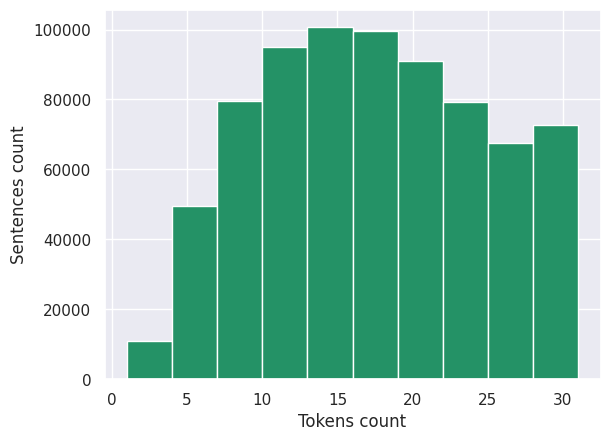

In [ ]:
sentence_length = list(map(lambda i:len(i), wordlists))
plt.hist(sentence_length)
plt.xlabel('Tokens count')
plt.ylabel('Sentences count')
plt.show()

Видим, что длина большей чати предложений находится в диапазоне: [7;25]. Предложения размером меньше 5 слов являются для данного датасета аномалиями. Предложения размером меньше 3-х слов могут оказаться анамольным случайным набором строк, удалим их.

In [ ]:
min_length = 3
wordlists = list(i for i in wordlists if len(i) > min_length)
print("Количество предложений, длина которых больше 3:", len(wordlists))

Количество предложений, длина которых больше 3: 734878


In [ ]:
words = Counter()
# Расчет встречаемости слов
for wordlist in tqdm(wordlists):
    for word in wordlist:
        words[word] += 1

  0%|          | 0/734878 [00:00<?, ?it/s]

In [ ]:
len(words)

147508

In [ ]:
words.most_common()[:10]

[('.', 642475),
 ('the', 593108),
 (',', 446927),
 ('a', 294028),
 ('and', 286184),
 ('of', 246170),
 ('to', 236450),
 ('is', 222401),
 ('it', 198566),
 ('i', 187729)]

In [ ]:
words.most_common()[-10:]

[('builing', 1),
 ('3.29', 1),
 ('runaround', 1),
 ('reconisably', 1),
 ('images.', 1),
 ('fabric-hall', 1),
 ('treatin', 1),
 ('did-so', 1),
 ('actor.ida', 1),
 ('diversionary', 1)]

Добавим в словарь ```vocab_size``` самых встречающихся слов.

In [ ]:
vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
vocab_size = 40000
# Наполнение словаря
for word in sorted(words, key=words.get, reverse=True)[:vocab_size]:
        vocab.add(word)

In [ ]:
assert '<unk>' in vocab
assert '<bos>' in vocab
assert '<eos>' in vocab
assert '<pad>' in vocab
assert len(vocab) == vocab_size + 4

In [ ]:
print("Всего слов в словаре:", len(vocab))

Всего слов в словаре: 40004


### Подготовка датасета (1 балл)

Далее, как и в семинарском занятии, подготовим датасеты и даталоадеры.

В классе ```WordDataset``` вам необходимо реализовать метод ```__getitem__```, который будет возвращать сэмпл данных по входному idx, то есть список целых чисел (индексов слов).

Внутри этого метода необходимо добавить служебные токены начала и конца последовательности, а также токенизировать соответствующее предложение с помощью ```word_tokenize``` и сопоставить ему индексы из ```word2ind```.

In [ ]:
word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

In [ ]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [word2ind.get(word, self.unk_id) for word in self.data[idx]]
        tokenized_sentence += [self.eos_id]

        return tokenized_sentence

    def __len__(self) -> int:
        return len(self.data)

In [ ]:
def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>']) -> torch.Tensor:
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = max(seq_lens)

    new_batch = []
    for sequence in input_batch:
        for _ in range(max_seq_len - len(sequence)):
            sequence.append(pad_id)
        new_batch.append(sequence)

    sequences = torch.LongTensor(new_batch).to(device)

    new_batch = {
        'input_ids': sequences[:,:-1],
        'target_ids': sequences[:,1:] # сдвигаем на 1 слово вперед
    }

    return new_batch

In [ ]:
train_sentences, eval_sentences = train_test_split(wordlists, test_size=0.2)
eval_sentences, test_sentences = train_test_split(eval_sentences, test_size=0.5)

train_dataset = WordDataset(train_sentences)
eval_dataset = WordDataset(eval_sentences)
test_dataset = WordDataset(test_sentences)

batch_size = 128

train_dataloader = DataLoader(
    train_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

test_dataloader = DataLoader(
    test_dataset, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Обучение и архитектура модели

Вам необходимо на практике проверить, что влияет на качество языковых моделей. В этом задании нужно провести серию экспериментов с различными вариантами языковых моделей и сравнить различия в конечной перплексии на тестовом множестве.

Возможные идеи для экспериментов:

* Различные RNN-блоки, например, LSTM или GRU. Также можно добавить сразу несколько RNN блоков друг над другом с помощью аргумента num_layers. Вам поможет официальная документация [здесь](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
* Различные размеры скрытого состояния. Различное количество линейных слоев после RNN-блока. Различные функции активации.
* Добавление нормализаций в виде Dropout, BatchNorm или LayerNorm
* Различные аргументы для оптимизации, например, подбор оптимального learning rate или тип алгоритма оптимизации SGD, Adam, RMSProp и другие
* Любые другие идеи и подходы

После проведения экспериментов необходимо составить таблицу результатов, в которой описан каждый эксперимент и посчитана перплексия на тестовом множестве.

Учтите, что эксперименты, которые различаются, например, только размером скрытого состояния или количеством линейных слоев считаются, как один эксперимент.

Успехов!

### Функция evaluate (1 балл)

Заполните функцию ```evaluate```

In [ ]:
def evaluate(model, criterion, dataloader) -> float:
    model.eval()
    perplexity = []
    with torch.no_grad():
        for batch in dataloader:
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1) # Посчитайте логиты предсказаний следующих слов
            loss = criterion(logits, batch['target_ids'].flatten())
            perplexity.append(torch.exp(loss).item())

    perplexity = sum(perplexity) / len(perplexity)

    return perplexity

### Train loop (1 балл)

Напишите функцию для обучения модели.

In [ ]:
def train_model(model, train_dataloader, eval_dataloader, num_epoch:int = 5):
    losses = []
    perplexities_train = []
    perplexities_eval = []

    fixedseed()
    model = model
    fixedseed()
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    fixedseed()
    optimizer = torch.optim.Adam(model.parameters())

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch+1}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())

        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities_train.append(evaluate(model, criterion, train_dataloader))
        perplexities_eval.append(evaluate(model, criterion, eval_dataloader))

    return model, losses, perplexities_train, perplexities_eval

Напишем вспомогательную функцию для отрисовки графиков loss и perplexity (train & eval)

In [ ]:
def plotting(losses: List, perplexities_tr: List, perplexities_eval: List):
    plt.figure(figsize=(10,2))
    plt.plot(np.arange(len(losses)), losses)
    plt.title('Losses')
    plt.xlabel("epoch")
    plt.show()
    print(f'Train loss: {min(losses)}')

    plt.figure(figsize=(10,2))
    plt.plot(np.arange(len(perplexities_tr)), perplexities_tr)
    plt.title('Perplexity on the trainset')
    plt.xlabel("epoch")
    plt.show()
    print(f'Perplexity on the trainset: {min(perplexities_tr)}')

    plt.figure(figsize=(10,2))
    plt.plot(np.arange(len(perplexities_eval)), perplexities_eval)
    plt.title('Perplexity on the evalset')
    plt.xlabel("epoch")
    plt.show()
    print(f'Perplexity on the evalset: {min(perplexities_eval)}')

### Первый эксперимент (2 балла)

Определите архитектуру модели и обучите её.

#### **В качестве базовой модели будем использовать GRU**:
* hidden_dim = 256
* "нежный" dropout = 0.05 после нелинейной тангенциальной активации перед линейным выходом

In [ ]:
class LanguageModel(nn.Module):
  def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True) # GRU layer
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size) # отображает векторы скрыт состояний в размер словаря

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.05)

  def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

In [ ]:
# Обучите модель здесь
num_epoch = 5

model = LanguageModel(hidden_dim=256, vocab_size=len(vocab)).to(device)
GRU, GRU_losses, GRU_tr_perplexities, GRU_ev_perplexities = train_model(model, train_dataloader, eval_dataloader, num_epoch)

Training epoch 1::   0%|          | 0/4593 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/4593 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/4593 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/4593 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/4593 [00:00<?, ?it/s]

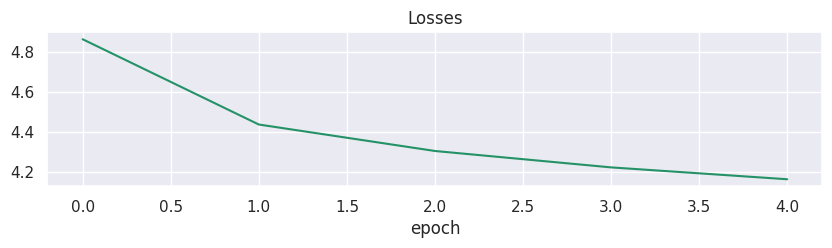

Train loss: 4.165813350324508


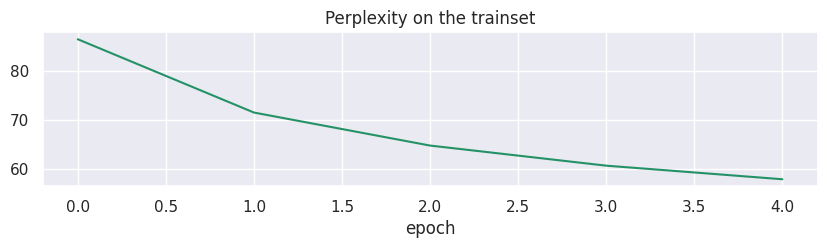

Perplexity on the trainset: 57.955644014949456


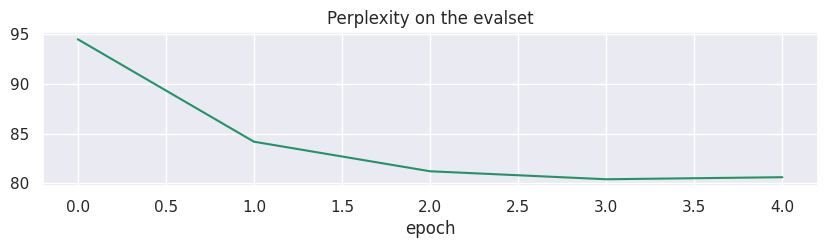

Perplexity on the evalset: 80.4172836900794


In [ ]:
plotting(GRU_losses, GRU_tr_perplexities, GRU_ev_perplexities)

**Запустим базовую модель на тестовом датасете**

In [ ]:
%%time
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
model_GRU = GRU.to(device)
GRU_test_perplexity = evaluate(model_GRU, criterion, test_dataloader)
GRU_test_perplexity

CPU times: user 21.5 s, sys: 10.9 ms, total: 21.5 s
Wall time: 21.5 s


80.7459641962466

In [ ]:
model_GRU

LanguageModel(
  (embedding): Embedding(40004, 256)
  (rnn): GRU(256, 256, batch_first=True)
  (linear): Linear(in_features=256, out_features=256, bias=True)
  (projection): Linear(in_features=256, out_features=40004, bias=True)
  (non_lin): Tanh()
  (dropout): Dropout(p=0.05, inplace=False)
)

#### GRU LM generation test: q -> r

In [ ]:
def generate_sequence(model, starting_seq: str, max_seq_len: int = 128) -> str:
    device = 'cuda'
    model = model.to(device)
    input_ids = [word2ind['<bos>']] + [
        word2ind.get(word, word2ind['<unk>']) for word in nltk.word_tokenize(starting_seq)]
    input_ids = torch.LongTensor(input_ids).to(device)

    model.eval()
    with torch.no_grad():
        for i in range(max_seq_len):
            next_word_distribution = model(input_ids)[-1]
            next_word = next_word_distribution.squeeze().argmax()
            input_ids = torch.cat([input_ids, next_word.unsqueeze(0)])

            if next_word.item() == word2ind['<eos>']:
                break

    words = ' '.join([ind2word[idx.item()] for idx in input_ids])

    return words

In [ ]:
test_list = [
    'i would highly recommend this film, especially ',
    'too bad only a few people saw this film, this film ',
    'i hate films about war and violence, but ',
    'the film is just ',
    'film wins the award it ',
    'mention specific elements of the film which caught your attention, like '
]

In [ ]:
for l in range(len(test_list)):
    print('Query:', test_list[l])
    print('Response generator GRU:', generate_sequence(model_GRU, starting_seq=test_list[l]))

Query: i would highly recommend this film, especially 
Response generator GRU: <bos> i would highly recommend this film , especially if you are a fan of the <unk> . <eos>
Query: too bad only a few people saw this film, this film 
Response generator GRU: <bos> too bad only a few people saw this film , this film was a waste of time . <eos>
Query: i hate films about war and violence, but 
Response generator GRU: <bos> i hate films about war and violence , but this is a great movie . <eos>
Query: the film is just 
Response generator GRU: <bos> the film is just a bit of a letdown . <eos>
Query: film wins the award it 
Response generator GRU: <bos> film wins the award it is a great film . <eos>
Query: mention specific elements of the film which caught your attention, like 
Response generator GRU: <bos> mention specific elements of the film which caught your attention , like the first film , and the <unk> of the film . <eos>


**Отметим, что**:
* базовая модель, в целом, "старается" генерировать текст,опираясь на полученный запрос, правда, старается "навязать" свою бинарную"эмоциональную" оценку, иногда, совсем невпопад, как при генерации на последний запрос;
* также сразу видны проблемы с генерацией токенов в конце последовательности: видимо, используемый здесь "жадный" алгоритм генерации и неуверенность модели (перплексия > 80 на тесте, условно, говорит о том, что модель при генерации каждого токена сомневается между 80 кандидатами) не позволяют модели до конца "выразить мысль" при ответе на запрос.

### Второй эксперимент (2 балла)

Попробуйте что-то поменять в модели или в пайплайне обучения, идеи для экспериментов можно подсмотреть выше.

#### **Во втором эксперименте будем использовать LSTM**:
* hidden_dim = 512: гипотетически увеличение размера скрытого слоя должно помочь выявить и обобщить большее количество связей между токенами в выборке;
* num_layers=2: добавим еще один рекуррентный слой, дабы модель попыталась выявить разноуровневые закономерности в тексте;
* dropout = 0.15 как после нелинейной тангенциальной активации перед линейным выходом, так и между рекуррентными слоями: при увеличении размера скрытого слоя + при добавлении доп. рекуррентного слоя модель может с большей вероятностью переобучиться

In [ ]:
# Проведите второй эксперимент
class LM_LSTM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int):
        super().__init__()
        # Опишите свою нейронную сеть здесь
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, num_layers=2, dropout=0.15) # добавим доп рекуррентный слой и между ними - dropout layer
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, vocab_size)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.15)

    def forward(self, input_batch: torch.Tensor) -> torch.Tensor:
        # А тут опишите forward pass модели
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, seq_len, hidden_dim]
        projection = self.projection(self.non_lin(output))  # [batch_size, seq_len, vocab_size]

        return projection

**Инициализируем веса методом Ксавье случайными числами из нормального распределения**

In [ ]:
def init_weights(self):
  for name, param in self.named_parameters():
    if 'bias' in name:
      nn.init.constant(param, 0.)
    elif 'weight' in name:
      nn.init.xavier_uniform(param)

**Немного дополним наш train loop:**

*   в качестве оптимизатора будем использовать модификацию Adam - AdamW (использует l2-регуляризацию, должен помочь от возможного затухания градиента)


In [ ]:
def train_model(model, train_dataloader, eval_dataloader, num_epoch:int = 5):
    losses = []
    perplexities_train = []
    perplexities_eval = []

    fixedseed()
    model = model
    fixedseed()
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    fixedseed()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3,betas=(0.5, 0.999),
                                      eps=1e-8, weight_decay=1e-3) # AdamW
   # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, # ReduceLROnPlateau scheduler
                                                           #patience=1)

    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for batch in tqdm(train_dataloader, desc=f'Training epoch {epoch+1}:'):
            optimizer.zero_grad()
            logits = model(batch['input_ids']).flatten(start_dim=0, end_dim=1)
            loss = criterion(logits, batch['target_ids'].flatten())
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        #scheduler.step(sum(epoch_losses) / len(epoch_losses)) # add scheduler.step
        losses.append(sum(epoch_losses) / len(epoch_losses))
        perplexities_train.append(evaluate(model, criterion, train_dataloader))
        perplexities_eval.append(evaluate(model, criterion, eval_dataloader))

    return model, losses, perplexities_train, perplexities_eval

In [ ]:
num_epoch = 7
model = LM_LSTM(hidden_dim=512, vocab_size=len(vocab)).apply(init_weights).to(device) # увеличим размер hidden_dim до 512
LSTM, LSTM_losses, LSTM_tr_perplexities, LSTM_ev_perplexities = train_model(model, train_dataloader, eval_dataloader, num_epoch)

/tmp/ipykernel_30/1841153875.py:6: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  nn.init.xavier_uniform(param)
/tmp/ipykernel_30/1841153875.py:4: FutureWarning: `nn.init.constant` is now deprecated in favor of `nn.init.constant_`.
  nn.init.constant(param, 0.)


Training epoch 1::   0%|          | 0/4593 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/4593 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/4593 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/4593 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/4593 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/4593 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/4593 [00:00<?, ?it/s]

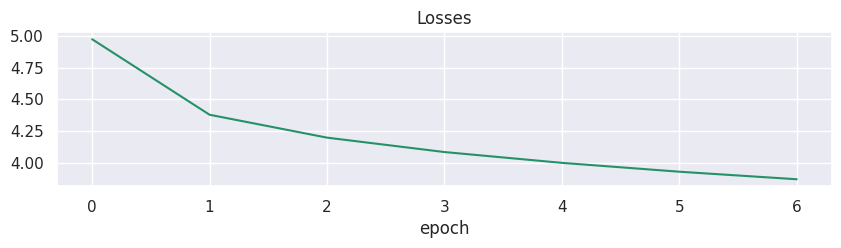

Train loss: 3.869452365727407


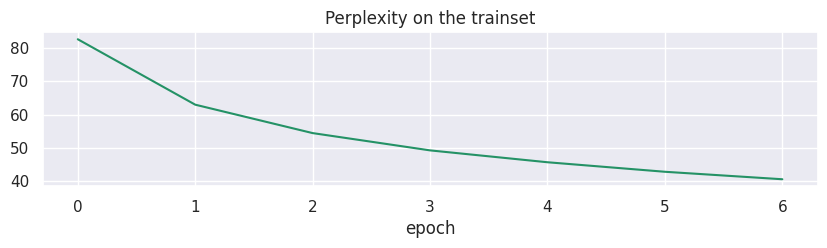

Perplexity on the trainset: 40.635457594306956


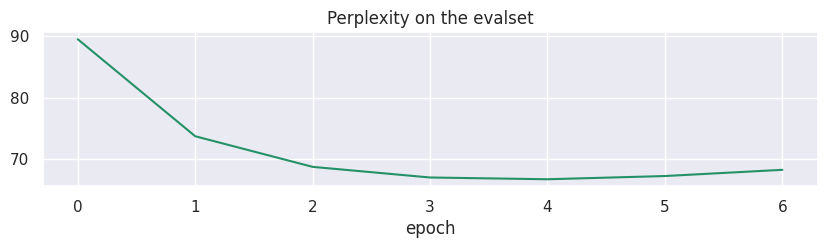

Perplexity on the evalset: 66.66959422899329


In [ ]:
plotting(LSTM_losses, LSTM_tr_perplexities, LSTM_ev_perplexities)

In [ ]:
%%time
criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
model_LSTM = LSTM.to(device)
LSTM_test_perplexity = evaluate(model_LSTM, criterion, test_dataloader)
LSTM_test_perplexity

CPU times: user 41.5 s, sys: 16.9 ms, total: 41.5 s
Wall time: 41.5 s


68.3429570206352

#### LSTM LM generation test: q -> r

Сначала выведем результат генерации базовой модели

In [ ]:
for l in range(len(test_list)):
    print('Query:', test_list[l])
    print('Response generator GRU:', generate_sequence(model_GRU, starting_seq=test_list[l]))

Query: i would highly recommend this film, especially 
Response generator GRU: <bos> i would highly recommend this film , especially if you are a fan of the <unk> . <eos>
Query: too bad only a few people saw this film, this film 
Response generator GRU: <bos> too bad only a few people saw this film , this film was a waste of time . <eos>
Query: i hate films about war and violence, but 
Response generator GRU: <bos> i hate films about war and violence , but this is a great movie . <eos>
Query: the film is just 
Response generator GRU: <bos> the film is just a bit of a letdown . <eos>
Query: film wins the award it 
Response generator GRU: <bos> film wins the award it is a great film . <eos>
Query: mention specific elements of the film which caught your attention, like 
Response generator GRU: <bos> mention specific elements of the film which caught your attention , like the first film , and the <unk> of the film . <eos>


**Сравним с LSTM**

In [ ]:
for l in range(len(test_list)):
    print('Query:', test_list[l])
    print('Response generator LSTM:', generate_sequence(model_LSTM, starting_seq=test_list[l]))

Query: i would highly recommend this film, especially 
Response generator LSTM: <bos> i would highly recommend this film , especially if you are a fan of the genre . <eos>
Query: too bad only a few people saw this film, this film 
Response generator LSTM: <bos> too bad only a few people saw this film , this film was a great disappointment . <eos>
Query: i hate films about war and violence, but 
Response generator LSTM: <bos> i hate films about war and violence , but this is a very good movie . <eos>
Query: the film is just 
Response generator LSTM: <bos> the film is just a little bit of a letdown . <eos>
Query: film wins the award it 
Response generator LSTM: <bos> film wins the award it deserves . <eos>
Query: mention specific elements of the film which caught your attention, like 
Response generator LSTM: <bos> mention specific elements of the film which caught your attention , like the first one . <eos>


**Видим, что модель LSTM:**
* более разнообразна, более точна;
* меньше "сомневается", то есть не генерирует <unk>;
* существенно лучше улавливает контекст запроса;
* модель, очевидно, в частности за счет большего размера скрытого слоя, смогла уловить разнообразные связи в выборке, что проявляется в менее банальных ответах на запросы с мал контекстом: ср., the film is just ---> the film is just a little bit of a letdown

#### Comparative_Plots of GRU & LSTM perplexities on train & test datasets

In [ ]:
def comparative_plots(perplex_gru: List, perplex_lstm: List, sample: str):
    plt.figure(figsize=(10,2))
    plt.plot(perplex_gru, 'b', label='Model_GRU')
    plt.plot(perplex_lstm, 'g', label='Model_LSTM')
    plt.title(f'Perplexities on {sample}: GRU vs. LSTM')
    plt.xlabel('Epoch')
    plt.ylabel('Perplexity')
    plt.legend()
    plt.show()
    print('Model_GRU best result',min(perplex_gru))
    print('Model_LSTM best result',min(perplex_lstm))

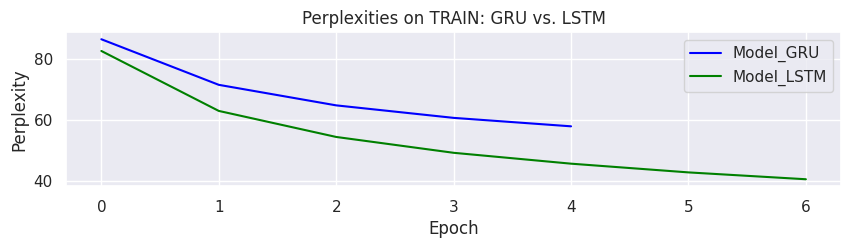

Model_GRU best result 57.955644014949456
Model_LSTM best result 40.635457594306956


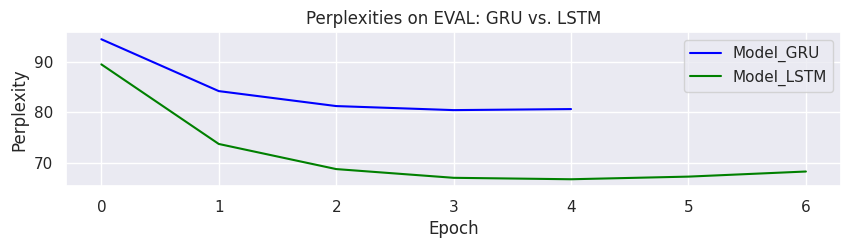

Model_GRU best result 80.4172836900794
Model_LSTM best result 66.66959422899329


In [ ]:
comparative_plots(GRU_tr_perplexities,LSTM_tr_perplexities, 'TRAIN')
comparative_plots(GRU_ev_perplexities,LSTM_ev_perplexities, 'EVAL')

In [ ]:
import pandas as pd
def perplexity_table(per_tr_1: List, per_tr_2: List, per_eval_1: List, per_eval_2: List, n_epoch:int=5):
    df = pd.DataFrame({'Model_GRU_tr':per_tr_1,'Model_GRU_eval':per_eval_1,'Model_LSTM_tr': per_tr_2, 'Model_LSTM_eval': per_eval_2})
    display(df.describe())
    df = df.T
    df.columns = [f'epoch_{i+1}' for i in range(n_epoch)]
    return df

In [ ]:
import pandas as pd
def perplexity_table(model_name, tr_perplexities, ev_perplexities, n_epochs):
    df = pd.DataFrame({model_name + '_train':tr_perplexities,
                       model_name + '_eval':ev_perplexities})
    df = df.T
    df.columns = [f'epoch_{i+1}' for i in range(n_epochs)]
    return df

In [ ]:
display(perplexity_table('GRU', GRU_tr_perplexities, GRU_ev_perplexities, 5))
print("\033[43m{}".format('GRU_test'), GRU_test_perplexity)
display(perplexity_table('LSTM', LSTM_tr_perplexities, LSTM_ev_perplexities, 7))
print("\033[42m{}".format('LSTM_test'), LSTM_test_perplexity)

,epoch_1,epoch_2,epoch_3,epoch_4,epoch_5
GRU_train,86.447741,71.531263,64.811432,60.720567,57.955644
GRU_eval,94.507505,84.196837,81.220827,80.417284,80.622662


GRU_test 80.7459641962466


,epoch_1,epoch_2,epoch_3,epoch_4,epoch_5,epoch_6,epoch_7
LSTM_train,82.614032,62.995619,54.474519,49.290768,45.732637,42.877165,40.635458
LSTM_eval,89.512311,73.684900,68.690611,66.955711,66.669594,67.193724,68.207489


LSTM_test 68.3429570206352


### Отчет (2 балла)

Опишите проведенные эксперименты. Сравните перплексии полученных моделей. Предложите идеи по улучшению качества моделей.

#### Предобработка текста:

1. Три датасета текстов были объеденены в один, после чего были удалены полные дубликаты, дабы при обучении не возникло утечки данных.
2. Количество предложений без дубликатов в получившемся датасете - 745800.
3. Длина большей части предложений находится в диапазоне: [7;25]. Так как предложения размером меньше 3 слов для данного датасета являются аномалиями, они были удалены.
4. Все слова в предложениях были приведены к нижнему регистру, произведена токенизация предложений и слов с помощью библиотеки nltk.

#### Эксперимент 1. Модель GRU с параметрами:
* размер скрытого слоя = 256;
* 1 рекуррентный слой;
* dropout = 0.05.
---
**После обучения на 5 эпохах получены следующие результаты:**
* loss, начиная со 2-й эпохи довольно уверенно уменьшается, также и перплексия на трейне и валид датасетах постепенно снижается  при увеличении количества эпох;
* можно отметить колебание на валид датасете на последней эпохе: очевидно, для сходимости требовалось большее количество эпох;
* **минимальное значение на трейне = 57.9, на евал = 80.6. Перплексия на тестовом дататесе = 80.74**;
* среднее время обучения на 1 эпохе - 15:35;
* генерация: иногда - совсем невпопад, иногда - "неуверенная", часто - "банальная" и очень предсказуемая.

---

#### Эксперимент 2. Модель LSTM с параметрами:
* размер скрытого слоя = 512;
* 2 рекуррентный слой;
* dropout между рекуррентными слоями  = 0.15;
* dropout перед выходом  = 0.15;
* для лучшей сходимости произведена инициализация весов Ксавье;
* использован оптимизатор AdamW
---
**После обучения на 7 эпохах получены следующие результаты:**
* loss, начиная со 2-й эпохи уверенно снижается на трейне, также и перплексия на трейне постепенно снижается  при увеличении количества эпох;
* при этом на валидации, с 6й эпохи, можно отметить небольшее увеличение перплексии: очевидно, для сходимости требовалось большее количество эпох;
* **минимальное значение на трейне = 40.6, на евал = 66.6. Перплексия на тестовом дататесе = 68.3**;
* среднее время обучения на 1 эпохе - 07:50;
* генерация: более разнообразна, более точна; модель меньше "сомневается", то есть не генерирует <unk>; существенно лучше улавливает контекст запроса; модель, очевидно, в частности за счет большего размера скрытого слоя, смогла уловить разнообразные связи в выборке, что проявляется в менее банальных ответах на запросы с мал контекстом.
---

**ИТОГ**. Несмотря на большее (в 2 раза) время обучения LSTM модели + небольшой задержки инференса, предпочтение, конечно, отдаем ей, если нужен не быстрый и предсказуемый "попугай", а более интересный "собеседник" ).

In [6]:
import asyncio
import os

PYPPETEER_CHROMIUM_REVISION = '1263111'

os.environ['PYPPETEER_CHROMIUM_REVISION'] = PYPPETEER_CHROMIUM_REVISION

from pyppeteer import launch


# async def generate_pdf(url, pdf_path):
#     browser = await launch()
#     page = await browser.newPage()
    
#     await page.goto(url)
    
#     await page.pdf({'path': pdf_path, 'format': 'A4'})
    
#     await browser.close()

# # Run the function
# asyncio.get_event_loop().run_until_complete(generate_pdf('https://example.com', 'example.pdf'))